# Imports and spark config

In [1]:
import os

# Set SPARK_HOME
os.environ["SPARK_HOME"] = r"C:/Spark/spark-3.5.0-bin-hadoop3"

# Set PYTHONPATH
spark_home = os.environ.get("SPARK_HOME", "")
if spark_home:
    python_path = os.path.join(spark_home, "python")
    py4j_zip = os.path.join(spark_home, "python", "lib", "py4j-0.10.9.7-src.zip")
    os.environ["PYTHONPATH"] = f"{python_path};{py4j_zip};{os.environ.get('PYTHONPATH', '')}"

# Set PYSPARK_PYTHON
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe"
print(os.environ.get('PYSPARK_PYTHON'))

# Set PATH
if spark_home:
    os.environ["PATH"] = f"{python_path};{os.path.join(spark_home, 'bin')};{os.environ.get('PATH', '')}"

C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe


In [2]:
import findspark
findspark.init()

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
spark = SparkSession.builder.appName("spark").config("spark.driver.memory", "24g").getOrCreate()
spark

In [4]:
# spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
# spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)

In [5]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Data preparation

## Initial setup

In [6]:
df = spark.read.parquet(r"c:\Users\Vincenzo\PROJECTS\DDAM_data\brewery\brewery_data_complete_extended.parquet")
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df.printSchema()
rows = df.count()
cols = len(df.columns)

print(f'Dimension of the Dataframe is: {(rows,cols)}')
df.show(5)

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

Dimension of the Dataframe is: (10000000, 20)
+--------+-------------------+----------+----+------------+--

## Sampling and df assignments

In [8]:
sample = df.sample(fraction=0.1, seed=42) #.drop("Batch_ID")

In [9]:
summary_stats = sample.toPandas().describe()
rounded_describe = np.round(summary_stats, 2)
rounded_describe

,Batch_ID,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
count,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00
mean,5004909.19,14.50,20.00,5.00,1.06,5.25,39.52,12.00,2749.48,10491.48,8.00,79.99,3.00,3.00,3.00
std,2887164.29,2.87,2.89,0.29,0.01,0.43,11.54,4.32,1298.31,5486.58,1.15,5.78,1.15,1.16,1.15
min,5.00,10.00,15.00,4.50,1.03,4.50,20.00,5.00,500.00,1000.00,6.00,70.00,1.00,1.00,1.00
25%,2502862.50,12.00,17.50,4.75,1.04,4.88,30.00,8.00,1624.00,5747.89,7.00,74.98,2.00,2.00,2.00
50%,5008192.00,15.00,20.00,5.00,1.06,5.25,40.00,12.00,2751.00,10486.75,8.00,79.99,3.00,3.00,3.00
75%,7506431.50,17.00,22.51,5.25,1.07,5.63,50.00,16.00,3874.00,15240.40,9.00,85.00,4.00,4.00,4.00
max,9999993.00,19.00,25.00,5.50,1.08,6.00,59.00,19.00,4999.00,19999.97,10.00,90.00,5.00,5.00,5.00


In [10]:
from pyspark.sql.functions import split, col

# Split the ratio_column into three parts based on the colon delimiter
split_col = split(col("Ingredient_Ratio"), ":")

# Create three separate columns for water, grains, and hops
sample = sample.withColumn("water", split_col.getItem(0).cast("double"))
sample = sample.withColumn("grains", split_col.getItem(1).cast("double"))
sample = sample.withColumn("hops", split_col.getItem(2).cast("double"))
sample = sample.drop("Ingredient_Ratio")
# Now you have three separate columns for water, grains, and hops with their respective values

In [11]:
# Define a new column with the USD per liter ratio
sample = sample.withColumn("USD_per_Liter", F.col("Total_Sales") / F.col("Volume_Produced").cast("double"))
sample = sample.withColumn("Brewing_efficency", F.col("Brewhouse_Efficiency") / F.col("Volume_Produced").cast("double"))

In [12]:
from pyspark.sql.types import StringType

# Identify numerical and non-numerical columns
numerical_cols = [col_name for col_name, data_type in sample.dtypes if data_type != 'string']
categorical_cols = [col_name for col_name, data_type in sample.dtypes if data_type == 'string']

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['Batch_ID', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'water', 'grains', 'hops', 'USD_per_Liter', 'Brewing_efficency']
Categorical columns: ['Brew_Date', 'Beer_Style', 'SKU', 'Location']


In [13]:
from pyspark.sql.functions import year, month 

plot_sample = sample.alias("plot_sample").withColumn("Year", year("Brew_Date")).withColumn("Month", month("Brew_Date"))

In [14]:
distinct_num_counts = {}

for col in numerical_cols:
    distinct_count = sample.select(col).distinct().count()
    distinct_num_counts[col] = distinct_count

    print(f"- {col} - {distinct_count} distinct values")

- Batch_ID - 1001591 distinct values
- Fermentation_Time - 10 distinct values
- Temperature - 1001591 distinct values
- pH_Level - 1001591 distinct values
- Gravity - 1001591 distinct values
- Alcohol_Content - 1001591 distinct values
- Bitterness - 40 distinct values
- Color - 15 distinct values
- Volume_Produced - 4500 distinct values
- Total_Sales - 1001591 distinct values
- Quality_Score - 1001591 distinct values
- Brewhouse_Efficiency - 1001591 distinct values
- Loss_During_Brewing - 1001591 distinct values
- Loss_During_Fermentation - 1001591 distinct values
- Loss_During_Bottling_Kegging - 1001591 distinct values
- water - 1 distinct values
- grains - 31 distinct values
- hops - 21 distinct values
- USD_per_Liter - 1001591 distinct values
- Brewing_efficency - 1001591 distinct values


In [16]:
distinct_cat_counts = {}

for col in categorical_cols:
    distinct_count = sample.select(col).distinct().count()
    distinct_cat_counts[col] = distinct_count

    print(f"- {col} - {distinct_count} distinct values")

- Brew_Date - 997634 distinct values
- Beer_Style - 8 distinct values
- SKU - 4 distinct values
- Location - 10 distinct values


## Low-values discrete variables analysis

### Functions

In [17]:
# functions

from pyspark.sql.functions import when, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, dense_rank, when
from pyspark.sql.window import Window

def ordinal_encode_pyspark(df, input_col, output_col):
    """ Ordinal encodes a column within a PySpark DataFrame

    Args:
        df (pyspark.sql.DataFrame): The input Spark DataFrame.
        input_col (str): Name of the column to be encoded. Defaults to "Bitterness".
        output_col (str): Name for the new ordinal encoded column. Defaults to "Bitterness_ordinal".
    
    Returns:
        pyspark.sql.DataFrame: The Spark DataFrame with the ordinal encoded column.
    """

    window = Window.orderBy(input_col) 
    return df.withColumn(output_col, dense_rank().over(window)) \
             .withColumn(output_col, when(col(input_col).isNull(), 0).otherwise(col(output_col))) \
             #.drop(input_col)
             
def check_distinct_values(df, feature_col):
    """  
    Prints the distinct values of a feature in a PySpark DataFrame.

    Args:
        df (pyspark.sql.DataFrame): The PySpark DataFrame.
        feature_col (str): The name of the feature column.
    """

    distinct_values = df.select(feature_col).distinct().collect()

    print(f"Distinct values in '{feature_col}':")
    for row in distinct_values:
        print(row[feature_col]) 

    # functions

def one_hot_encode_column(df, input_col, output_col_prefix="encoded"):
    """ One-hot encodes a specified categorical column, drops intermediary columns,
        and allows for specifying the prefix of the output columns.

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame.
        input_col (str): The name of the column containing categorical data.
        output_col_prefix (str): Prefix for the generated one-hot encoded column names.

    Returns:
        pyspark.sql.DataFrame: DataFrame with the one-hot encoded column(s) and 
                               intermediary columns removed.
    """

    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + "_index")
    encoder = OneHotEncoder(inputCol=input_col + "_index", outputCol=output_col_prefix + input_col + "features")
    assembler = VectorAssembler(inputCols=[input_col + "_index"], outputCol="features") 

    pipeline = Pipeline(stages=[indexer, assembler, encoder])
    transformed_df = pipeline.fit(df).transform(df)

    # Drop unnecessary columns
    drop_cols = [input_col, input_col + "_index", "features"]
    return transformed_df.drop(*drop_cols)  # Dynamic column dropping
def discretize_and_encode(df, input_col="fermentation_time"):
    """ Discretizes a feature into bins, one-hot encodes the bins, and preserves the original column

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame
        input_col (str): Name of the column to be discretized and encoded

    Returns:
        pyspark.sql.DataFrame:  DataFrame with new discretization and encoded columns
    """

    df = df.withColumn(input_col + "_bin", 
                       when((col(input_col) >= 10) & (col(input_col) <= 13), "Short")
                       .when((col(input_col) >= 14) & (col(input_col) <= 16), "Medium")
                       .otherwise("Long"))
    
    return one_hot_encode_column(df, input_col=input_col + "_bin") 

### Color

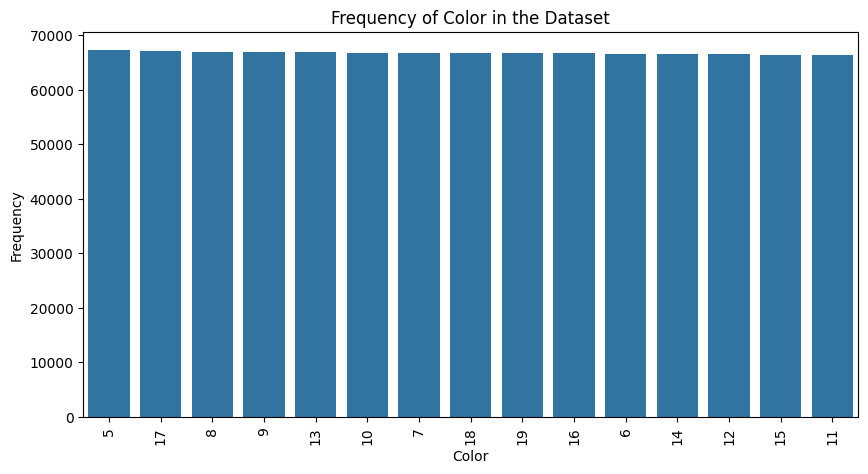

In [18]:
color_frequency = sample.groupBy("Color").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=color_frequency, x="Color", y="count", order=color_frequency.sort_values('count', ascending=False)["Color"])
plt.title('Frequency of Color in the Dataset')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [19]:
# sample = ordinal_encode_pyspark(sample, "Color", "Color_ordinal")
# sample.show(5)

# summary_stats = sample.select("Color_ordinal").toPandas().describe()
# rounded_describe = np.round(summary_stats, 2)
# rounded_describe

In [20]:
# color_frequency = sample.groupBy("Color_ordinal").count().toPandas()

# plt.figure(figsize=(10, 5))
# sns.barplot(data=color_frequency, x="Color_ordinal", y="count", order=color_frequency.sort_values('Color_ordinal', ascending=True)["Color_ordinal"])
# plt.title('Frequency of Color in the Dataset')
# plt.xlabel('Color')
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.show()


### Bitterness

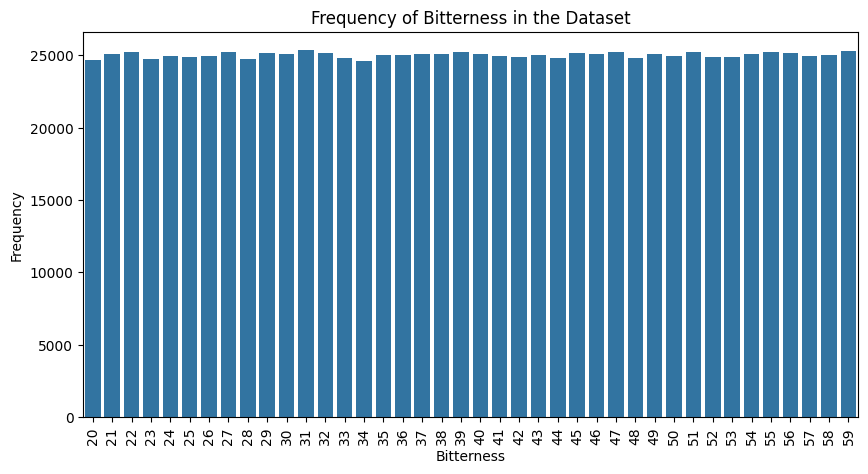

In [21]:
Bitterness_frequency = sample.groupBy("Bitterness").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=Bitterness_frequency, x="Bitterness", y="count", order=Bitterness_frequency.sort_values('Bitterness', ascending=True)["Bitterness"])
plt.title('Frequency of Bitterness in the Dataset')
plt.xlabel('Bitterness')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [22]:
# sample = ordinal_encode_pyspark(sample, "Bitterness", "Bitterness_ordinal") 
# sample.show(5)

# summary_stats = sample.select("Bitterness_ordinal").toPandas().describe()
# rounded_describe = np.round(summary_stats, 2)
# rounded_describe

In [23]:
# Bitterness_ordinal_frequency = sample.groupBy("Bitterness_ordinal").count().toPandas()

# plt.figure(figsize=(10, 5))
# sns.barplot(data=Bitterness_ordinal_frequency, x="Bitterness_ordinal", y="count", order=Bitterness_ordinal_frequency.sort_values('Bitterness_ordinal', ascending=True)["Bitterness_ordinal"])
# plt.title('Frequency of Bitterness_ordinal in the Dataset')
# plt.xlabel('Bitterness_ordinal')
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.show()


### Grains

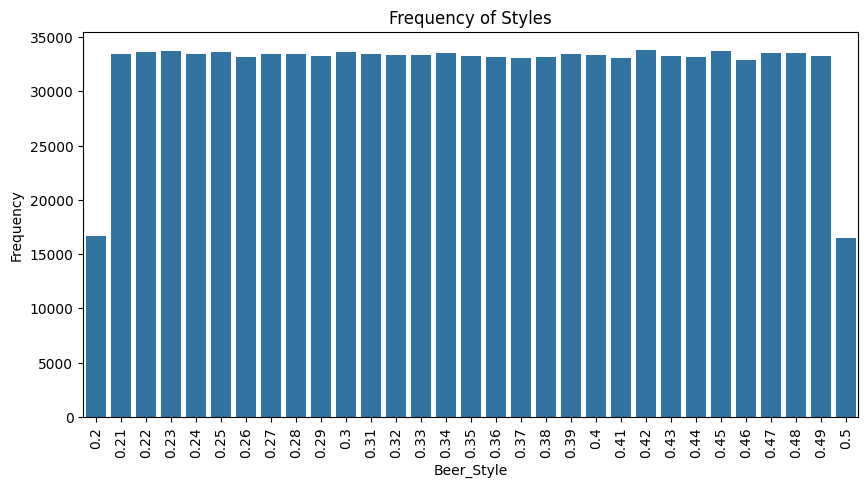

In [24]:
grains_frequency = sample.groupBy("grains").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=grains_frequency, x="grains", y="count", order=grains_frequency.sort_values('grains', ascending=True)["grains"])
plt.title('Frequency of Styles')
plt.xlabel('Beer_Style')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

### Hops

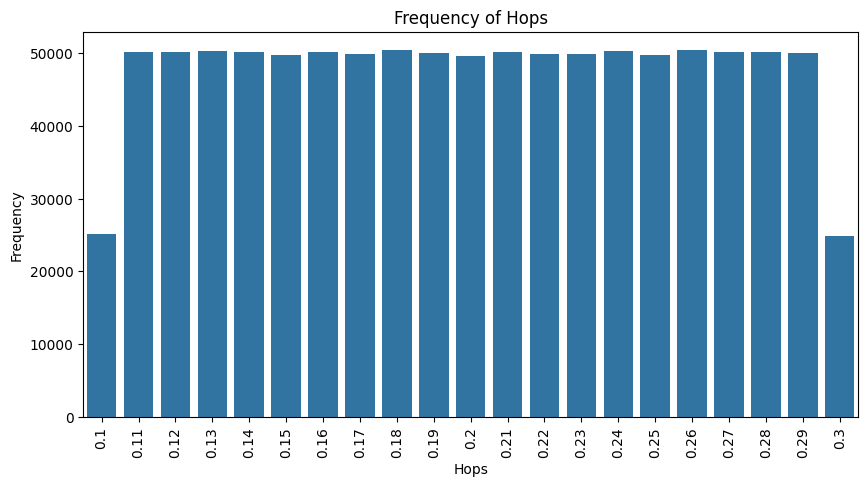

In [25]:
hops_frequency = sample.groupBy("hops").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=hops_frequency, x="hops", y="count", order=hops_frequency.sort_values('hops', ascending=True)["hops"])
plt.title('Frequency of Hops')
plt.xlabel('Hops')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

### Fermentation time

In [26]:
sample = discretize_and_encode(sample)
sample.select("encodedfermentation_time_binfeatures").show(5)

+------------------------------------+
|encodedfermentation_time_binfeatures|
+------------------------------------+
|                       (2,[0],[1.0])|
|                       (2,[0],[1.0])|
|                           (2,[],[])|
|                           (2,[],[])|
|                       (2,[0],[1.0])|
+------------------------------------+
only showing top 5 rows



In [27]:
# sample.select("encodedfermentation_time_binfeatures").toPandas().describe()

## Categorical variables analysis

### Beer style

In [28]:
sample = one_hot_encode_column(sample, "Beer_Style")
sample.select("encodedBeer_Stylefeatures").show(5)

+-------------------------+
|encodedBeer_Stylefeatures|
+-------------------------+
|            (7,[6],[1.0])|
|            (7,[0],[1.0])|
|                (7,[],[])|
|            (7,[6],[1.0])|
|            (7,[2],[1.0])|
+-------------------------+
only showing top 5 rows



In [29]:
# sample.select("encodedBeer_Stylefeatures").toPandas().describe()

### SKU

In [30]:
sample = one_hot_encode_column(sample, "SKU")
sample.select("encodedSKUfeatures").show(5)

+------------------+
|encodedSKUfeatures|
+------------------+
|     (3,[1],[1.0])|
|     (3,[0],[1.0])|
|         (3,[],[])|
|     (3,[2],[1.0])|
|     (3,[2],[1.0])|
+------------------+
only showing top 5 rows



In [31]:
# sample.select("encodedSKUfeatures").toPandas().describe()

### Location

In [32]:
sample = one_hot_encode_column(sample, "Location")
sample.select("encodedLocationfeatures").show(5)

+-----------------------+
|encodedLocationfeatures|
+-----------------------+
|          (9,[5],[1.0])|
|              (9,[],[])|
|          (9,[4],[1.0])|
|          (9,[0],[1.0])|
|          (9,[6],[1.0])|
+-----------------------+
only showing top 5 rows



In [33]:
# sample.select("encodedLocationfeatures").toPandas().describe()

In [34]:
sample.printSchema()

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- water: double (nullable = true)
 |-- grains: double (nullable = true)
 |-- hops: double (nullable = true)
 |-- USD_per_Liter: double (nullable = true)
 |-- Brewing_efficency: double (nullable = true)
 |-- encodedfermentation_time_binfeatures: vector (nullable = true)


# Data Exploration

In [35]:
import pyspark.sql.functions as F
print(f'We have data in a range from {plot_sample.select(F.min("year")).collect()[0][0]} to {plot_sample.select(F.max("year")).collect()[0][0]}')

We have data in a range from 2020 to 2023


## plots

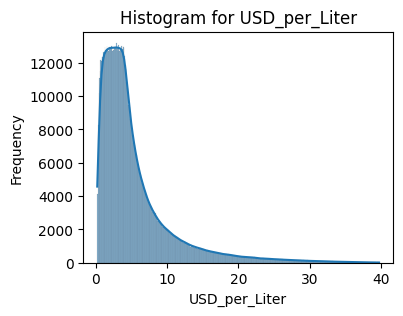

In [36]:
plt.figure(figsize=(4, 3))
sns.histplot(data=plot_sample.select("USD_per_Liter").toPandas(), x="USD_per_Liter", kde=True)

plt.title(f'Histogram for USD_per_Liter')
plt.xlabel("USD_per_Liter")
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Color', ylabel='count'>

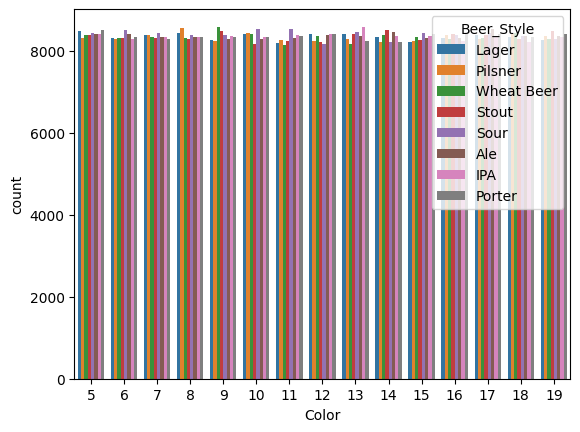

In [37]:
key_mode_count = plot_sample.groupBy('Color', 'Beer_Style').count().toPandas()
sns.barplot(x="Color", y="count", data=key_mode_count, hue='Beer_Style')

### Scatter plots

In [38]:
plot_sample = plot_sample.sample(fraction=0.1, seed=42)

#### losses against other

- brewhouse efficency (no patterns \ uniform)
- usd per liter (no patterns \ uniform)
- year (no patterns \ uniform)
- month (no patterns \ uniform)

<Axes: xlabel='Loss_During_Brewing', ylabel='Brewhouse_Efficiency'>

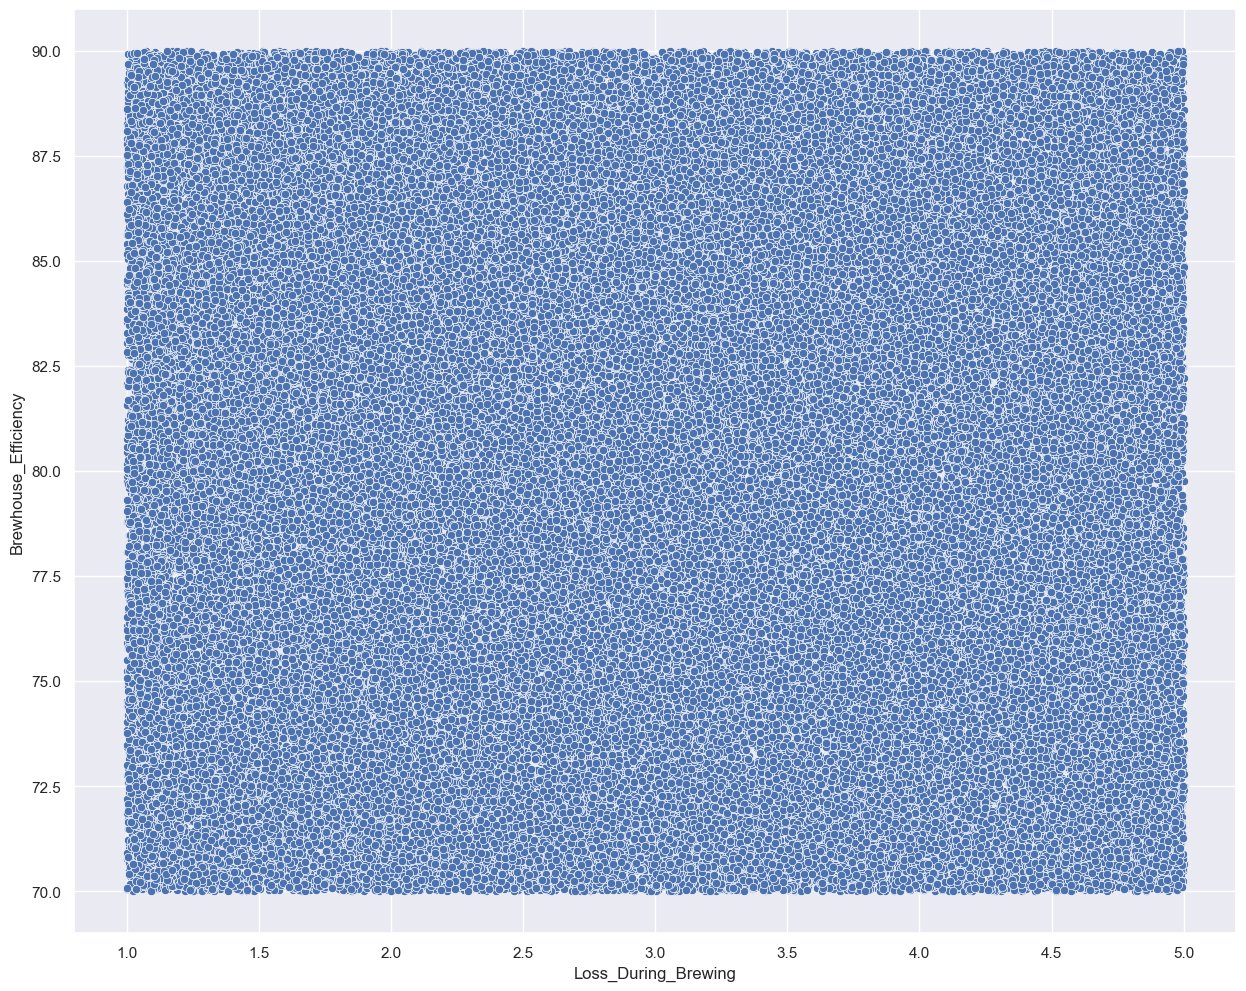

In [60]:
sns.scatterplot(data=plot_sample.toPandas(), x="Loss_During_Brewing", y="Brewhouse_Efficiency")

<Axes: xlabel='Loss_During_Fermentation', ylabel='Month'>

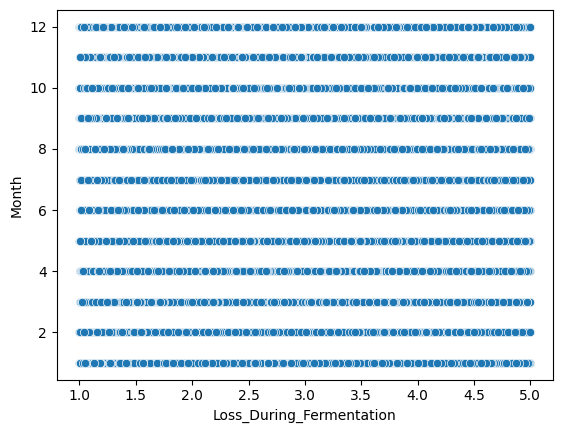

In [40]:
sns.scatterplot(data=plot_sample.toPandas(), x="Loss_During_Fermentation", y="Month")

<Axes: xlabel='Loss_During_Bottling_Kegging', ylabel='Month'>

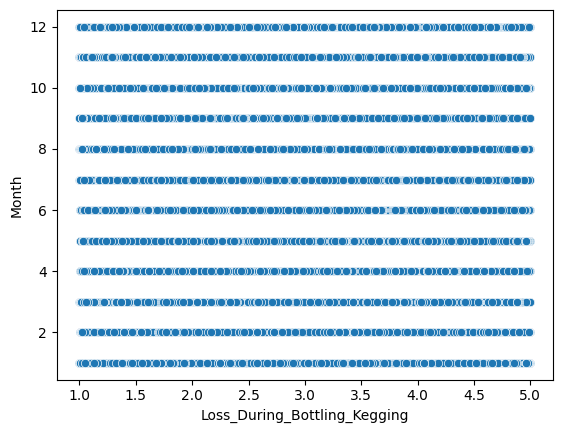

In [41]:
sns.scatterplot(data=plot_sample.toPandas(), x="Loss_During_Bottling_Kegging", y="Month")

#### quality scores against other

- Color (no patterns \ uniform)
- Alcohol_Content (no patterns \ uniform)
- Bitterness (no patterns \ uniform)
- volume produced (no patterns \ uniform)
- total sales (no patterns \ uniform)
- brewhouse efficency (no patterns \ uniform)
- usd per liter (no patterns \ uniform)

<Axes: xlabel='USD_per_Liter', ylabel='Quality_Score'>

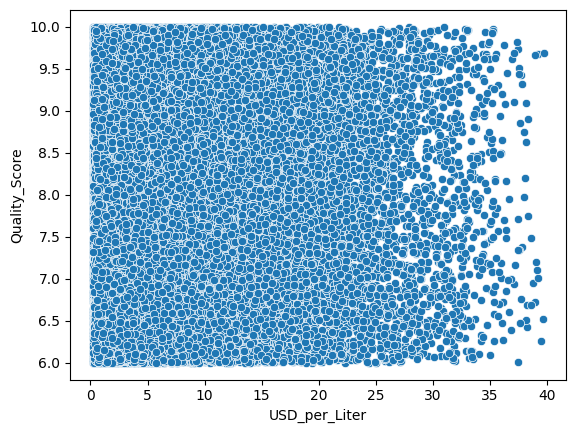

In [42]:
sns.scatterplot(data=plot_sample.toPandas(), x="USD_per_Liter", y="Quality_Score")

In [43]:
plot_sample.printSchema()

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- water: double (nullable = true)
 |-- grains: double (nullable = true)
 |-- hops: double (nullable = true)
 |-- USD_per_Liter: double (nullable = true)


## correlation

In [44]:
corr_sample = sample.drop("water", "Batch_ID","encodedBeer_Stylefeatures", "encodedSKUfeatures", "encodedLocationfeatures")
corr_sample = corr_sample.drop("Brew_Date", "encodedfermentation_time_binfeatures")
corr_sample.printSchema()

root
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- grains: double (nullable = true)
 |-- hops: double (nullable = true)
 |-- USD_per_Liter: double (nullable = true)
 |-- Brewing_efficency: double (nullable = true)



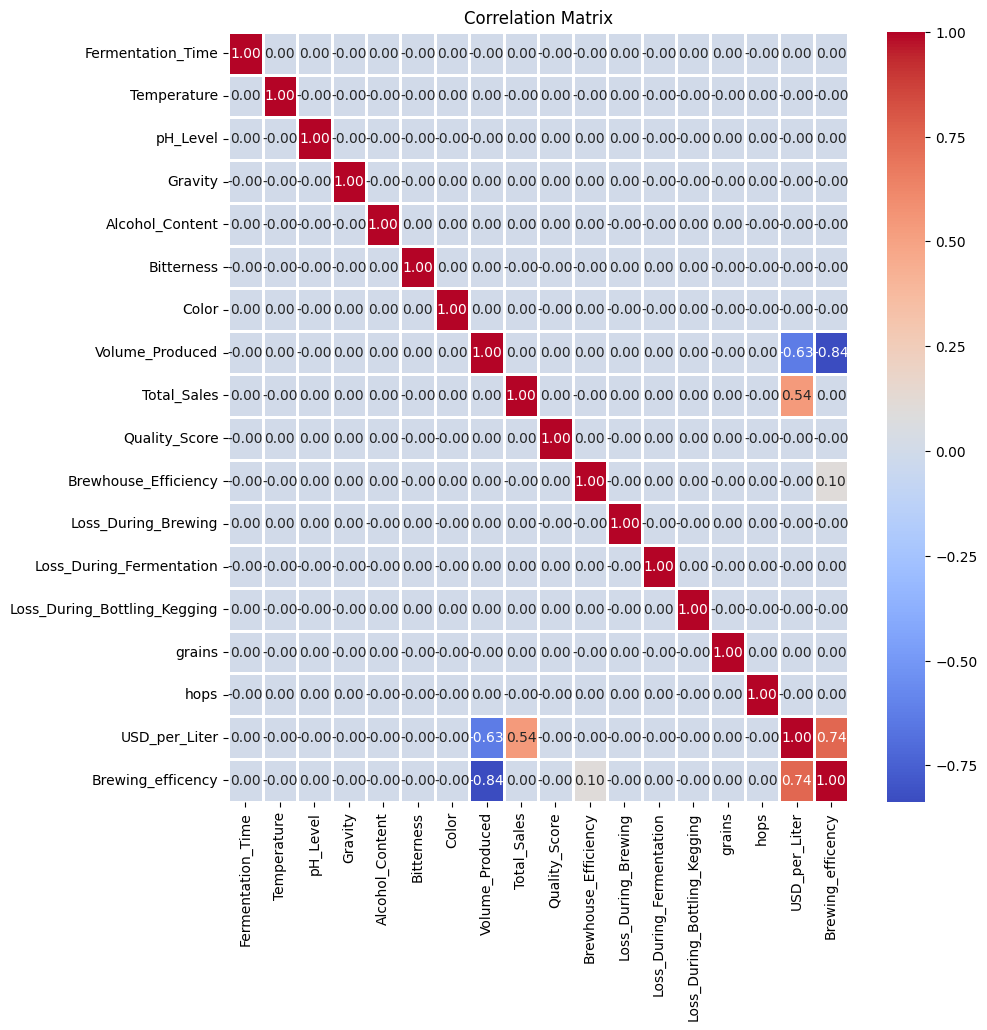

In [45]:
corr = corr_sample.toPandas().corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

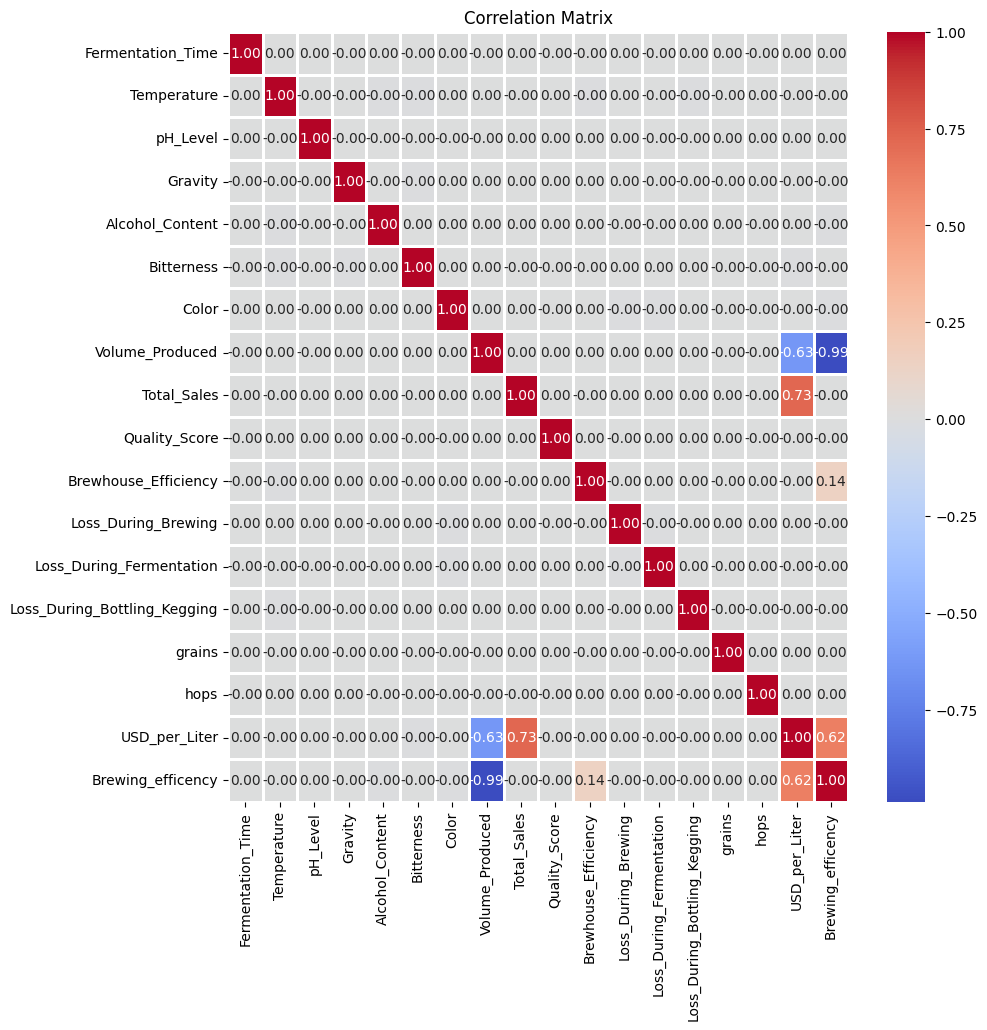

In [46]:
corr = corr_sample.toPandas().corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

c:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


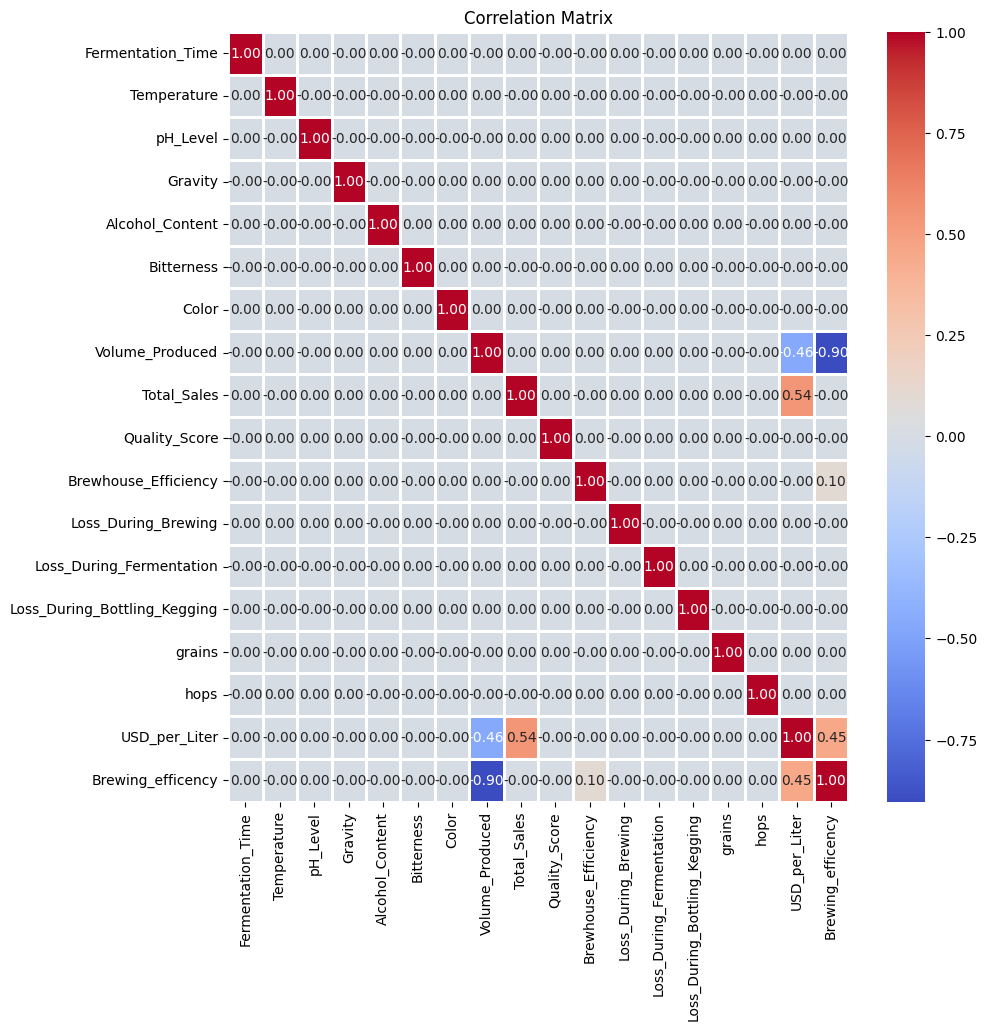

In [47]:
corr = corr_sample.toPandas().corr(method='kendall')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

In [48]:
from pyspark.ml.feature import VectorAssembler

features = corr_sample.schema.names
vectorassembler = VectorAssembler(inputCols = features, outputCol= 'assemblerfeatures')
output_dataset = vectorassembler.transform(corr_sample)  

<Axes: >

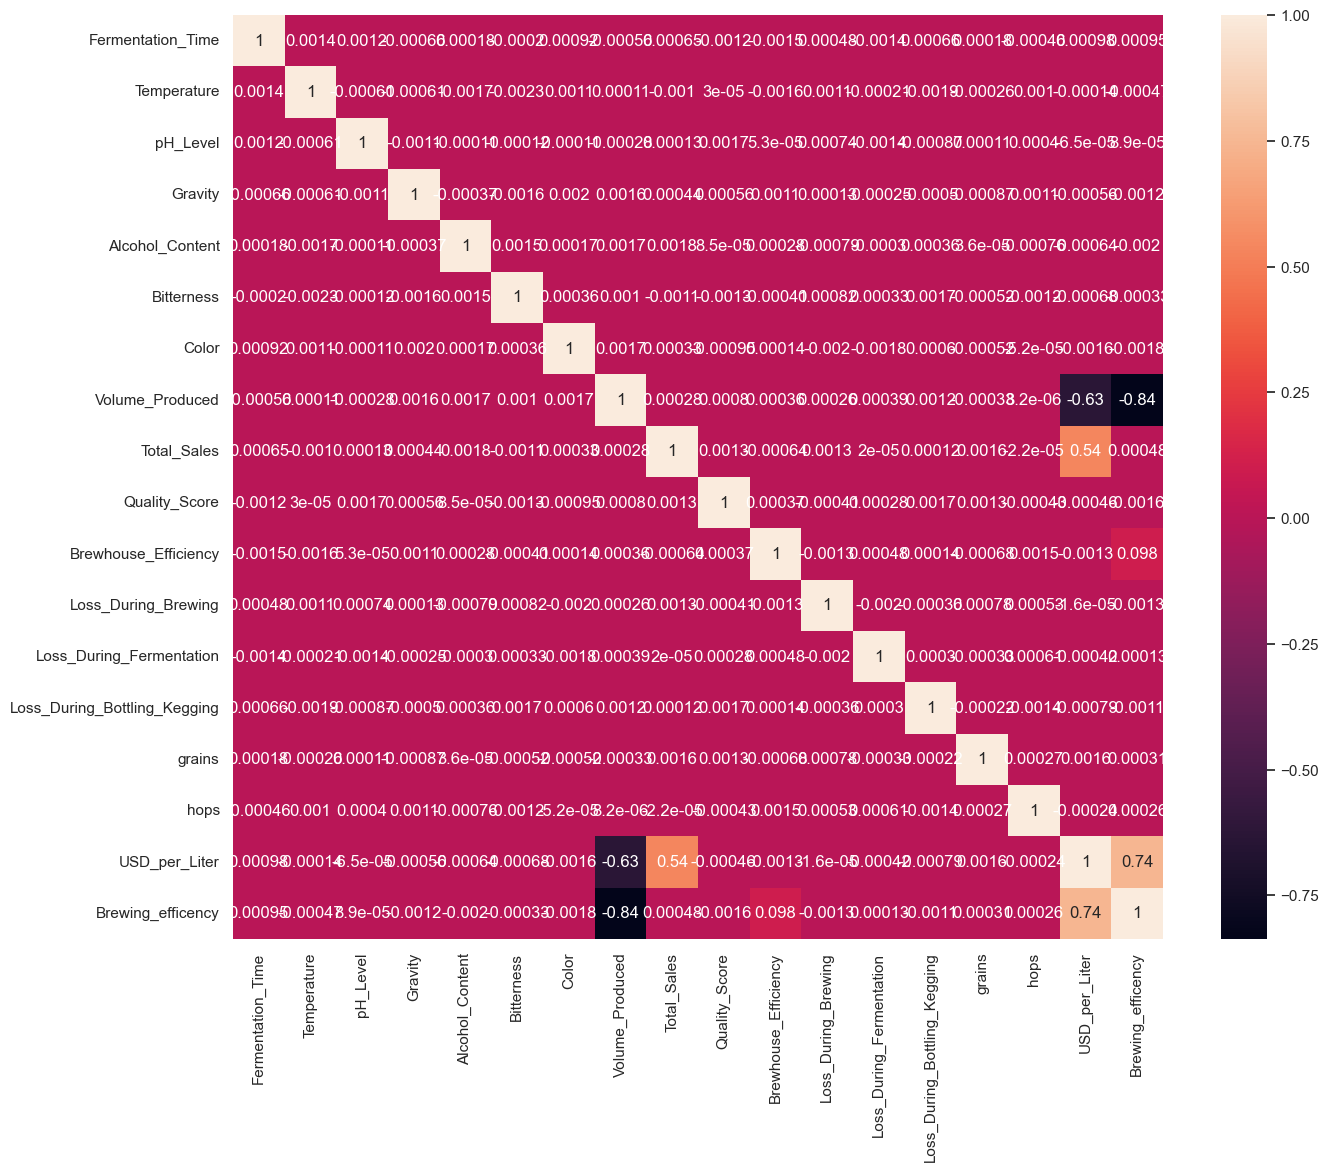

In [49]:
from pyspark.ml.stat import Correlation

pearsonCorr = Correlation.corr(output_dataset, 'assemblerfeatures', 'pearson').collect()[0][0]

#trasformo la DenseMatrix in un array numpy
correlation_array = pearsonCorr.toArray() #ritorna un numpy.ndarray

correlationDF = pd.DataFrame(
    correlation_array,
    index = features,
    columns = features
)

sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(correlationDF, annot=True)

# MachineLearning

Loss-Focused Prediction: Could you set up regression or classification models to predict if a batch tends to have higher brewing losses based on brew conditions (temperature, etc.)? This might provide insight on process adjustments to decrease loss percentage.
Efficiency Gains: What combinations of brewing factors have produced the highest Brewhouse Efficiency outcomes? Analyzing this could assist in streamlining processes for optimizing ingredient use.

## Intro

- Alcohol content

    - features = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                 "Bitterness", "Color", "grains", "hops"]
    - Regression on alcohol content
    - Classficiation on alcohol content bin
    - Anomaly detection on alcohol content

- Loss during processes

- Quality score

- Usd per liter

In [ ]:
sample.printSchema()

In [ ]:
sample.show(5)

## Alcohol content prediction task

### Regression

In [ ]:
sample.select("Alcohol_content").toPandas().describe()

#### Baseline

In [ ]:
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.evaluation import RegressionEvaluator

# # Feature Preparation
# features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
#                  "Bitterness", "Color", "grains", "hops"]

# # Dataset Preparation
# regr_alc_sample = sample.alias("regr_alc_sample")
# regr_alc_train, regr_alc_test = regr_alc_sample.randomSplit([0.8, 0.2], seed=42)

# assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
# train_df_transformed = assembler.transform(regr_alc_train)
# test_df_transformed = assembler.transform(regr_alc_test)

# # Standardization (Optional)
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
# scaler_model = scaler.fit(train_df_transformed)
# train_df_transformed = scaler_model.transform(train_df_transformed)
# test_df_transformed = scaler_model.transform(test_df_transformed)

# # Linear Regression Model
# lr = LinearRegression(featuresCol="features", labelCol="Alcohol_Content")
# lr_model = lr.fit(train_df_transformed)

# # Transformation
# train_predictions = lr_model.transform(train_df_transformed)
# test_predictions = lr_model.transform(test_df_transformed)

# # Evaluation (RMSE)
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="Alcohol_Content", predictionCol="prediction")
# train_rmse = evaluator.evaluate(train_predictions)
# test_rmse = evaluator.evaluate(test_predictions)
# print(f"Train RMSE: {train_rmse}")
# print(f"Test RMSE: {test_rmse}")

# # Model Coefficients (Feature Influence)
# print(lr_model.coefficients) 


#### Pipeline 

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.evaluation import RegressionEvaluator

# # Feature Preparation
# features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
#                 "Bitterness", "Color", "grains", "hops"]

# # 1. Vector Assembler:
# assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# # 2. Standard Scaler (If you decide to standardize):
# scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# # 3. Linear Regression Model:
# lr = LinearRegression(featuresCol="scaled_features", labelCol="Alcohol_Content") # FeaturesCol matches Scaler output


# # Pipeline for Modeling Stages Only
# pipeline = Pipeline(stages=[assembler, scaler, lr])

# # Dataset Preparation
# regr_alc_sample = sample.alias("regr_alc_sample")
# regr_alc_train, regr_alc_test = regr_alc_sample.randomSplit([0.8, 0.2], seed=42)

# # Fit the Pipeline:
# pipeline_model = pipeline.fit(regr_alc_train)

# # Transform (for predictions on both train and test)
# train_predictions = pipeline_model.transform(regr_alc_train)
# test_predictions = pipeline_model.transform(regr_alc_test)

# # Evaluation Stage (after getting predictions)
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="Alcohol_Content", predictionCol="prediction")
# train_rmse = evaluator.evaluate(train_predictions)
# test_rmse = evaluator.evaluate(test_predictions)

# print("Train Root Mean Squared Error (RMSE): %f" % train_rmse) 
# print("Test Root Mean Squared Error (RMSE): %f" % test_rmse) 

# # Access Coefficients
# lr_stage = pipeline_model.stages[2] # Access the fitted LinearRegression model
# print(lr_stage.coefficients) 


#### Pipeline crossval

In [72]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Feature Preparation
features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                "Bitterness", "grains", "hops"]

# 1. Vector Assembler:
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# 2. Standard Scaler (If you decide to standardize):
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# 3. Linear Regression Model:
lr = LinearRegression(featuresCol="scaled_features", labelCol="Alcohol_Content") # FeaturesCol matches Scaler output

# Grid Search for Hyperparameter Tuning

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross Validation
evaluator = RegressionEvaluator(metricName="r2", labelCol="Alcohol_Content", predictionCol="prediction")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Pipeline for Modeling Stages Only
pipeline = Pipeline(stages=[assembler, scaler, crossval])

# Dataset Preparation
regr_alc_sample = sample.alias("regr_alc_sample")
regr_alc_train, regr_alc_test = regr_alc_sample.randomSplit([0.8, 0.2], seed=42)

# Fit the Pipelines:
pipeline_model = pipeline.fit(regr_alc_train)

# Evaluation: After getting predictions
train_predictions = pipeline_model.transform(regr_alc_train)
test_predictions = pipeline_model.transform(regr_alc_test)
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

print("Train Root Mean Squared Error (RMSE): %f" % train_rmse)
print("Test Root Mean Squared Error (RMSE): %f" % test_rmse)

# Access Coefficients
best_lr_model = pipeline_model.stages[2].bestModel
print(best_lr_model.coefficients)


Train Root Mean Squared Error (RMSE): 0.000000
Test Root Mean Squared Error (RMSE): -0.000043
[0.0,0.0,0.0,0.0,0.0,0.0,0.0]


Interpreting Results

    RMSE: Evaluate the RMSE score. A lower value implies better average accuracy in predicting alcohol content using your features.
    
    Coefficients: Examine the sign (+/-) and magnitude of each feature's coefficient. These tell you:
        Positive Coefficient: Increases in this feature tend to associate with higher 'Alcohol_Content'.
        Negative Coefficient: Increases in this feature tend to associate with lower 'Alcohol_Content'.
        Magnitude: Larger the value (ignoring the sign), stronger the apparent impact of said feature, linearly speaking.


Interpreting the Results

    RMSE (0.432971): The context is crucial here. To judge whether this RMSE is "good" or "bad," consider the natural range of 'Alcohol_Content' values in your dataset.
        As a crude example, suppose 'Alcohol_Content' typically varies between 4% and 10%. Then a 0.43 error might be tolerable.
        If these alcohol values instead range from 4% to 5%, this same error becomes highly significant.

Analyzing Coefficients

Here's a breakdown of how to draw inferences from the model's coefficients:

    Sign:
        Positive coefficients suggest those features tend to be associated with higher alcohol content in your dataset.
        Negative coefficients imply an association with lower alcohol content.

    Magnitude: The larger the absolute value of a coefficient, the stronger its apparent linear influence on 'Alcohol_Content' is, all else being equal.

    Sparseness: Notice several coefficients (especially those for ingredient amounts) are very close to zero. This might mean these have practically negligible linear impact within the range of values encountered in your dataset.

Considerations

    Statistical Significance: This simple linear regression doesn't provide measures of statistical significance for each coefficient. Techniques exist to estimate confidence intervals, making more robust assertions about feature effect strength.

### Trees

Calculating Metrics
Python

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_true = regr_brewloss_test['Loss_During_Brewing'] # Actual Values
y_pred = test_predictions.select('prediction').collect() # Model Predictions

r2 = r2_score(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False) 
mae = mean_absolute_error(y_true, y_pred)

print('R-squared:', r2)
print('RMSE:', rmse)
print('MAE:', mae) 


Visualizing the Tree
Python

from sklearn import tree 
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) 
tree.plot_tree(your_dt_model, feature_names=features_cols, filled=True) 
plt.show()


Feature Importance
Python

feature_importances = your_dt_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1] # To show in descending order

print('Feature Importances:')
for f in range(len(features_cols)):
   print(features_cols[sorted_indices[f]], ':', feature_importances[sorted_indices[f]])


udf explanation site: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/

#### Decision tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                 "Bitterness", "grains", "hops",]

# Dataset preparation
tree_alc_sample = sample.alias("tree_alc_sample")
tree_alc_train, tree_alc_test = tree_alc_sample.randomSplit([0.8, 0.2], seed=42)

# Binarizing 'Alcohol_Content'
from pyspark.sql.functions import udf

def binarize(alcohol_value):
    if alcohol_value  <= 5.0:
        return "Low"
    elif alcohol_value <= 5.5:
        return "Medium"
    else:
        return "High"

binarize_udf = udf(binarize, StringType())
tree_alc_train = tree_alc_train.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))
tree_alc_test = tree_alc_test.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))

# Encoding 'Alcohol_Bin' this solves the stringtype issue for the onehotencoder
tree_alc_train = tree_alc_train.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2))

tree_alc_test = tree_alc_test.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2)) 

# Feature Preparation
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")  
train_df_transformed = assembler.transform(tree_alc_train)
test_df_transformed = assembler.transform(tree_alc_test)

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Alcohol_Bin")
dt_model = dt.fit(train_df_transformed)

# Predictions
predictions = dt_model.transform(test_df_transformed)

# Evaluation (For Classification)
evaluator = MulticlassClassificationEvaluator(labelCol="Alcohol_Bin", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: %f" % accuracy) 

# Visualization (may need external libraries depending on your setup)
print(dt_model.toDebugString) 


#### Decision Tree - pipeline crossval scaler

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator


features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                 "Bitterness", "grains", "hops",]
# Dataset preparation
tree_alc_sample = sample.alias("tree_alc_sample")
tree_alc_train, tree_alc_test = tree_alc_sample.randomSplit([0.8, 0.2], seed=42)

# Binarizing 'Alcohol_Content'
from pyspark.sql.functions import udf

def binarize(alcohol_value):
    if alcohol_value  <= 5.0:
        return "Low"
    elif alcohol_value <= 5.5:
        return "Medium"
    else:
        return "High"

binarize_udf = udf(binarize, StringType())
tree_alc_train = tree_alc_train.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))
tree_alc_test = tree_alc_test.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))

# Encoding 'Alcohol_Bin' this solves the stringtype issue for the onehotencoder
tree_alc_train = tree_alc_train.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2))

tree_alc_test = tree_alc_test.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2)) 

# Feature Preparation
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")  

# Standardization (Optional)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Alcohol_Bin")

# Parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.maxBins, [16, 32]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

# Cross Validation
evaluator = MulticlassClassificationEvaluator(labelCol="Alcohol_Bin", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Pipeline for Modeling Stages Only
pipeline = Pipeline(stages=[assembler, crossval])

# Fit the Pipelines:
pipeline_model = pipeline.fit(tree_alc_train)

# Evaluation: After getting predictions
train_predictions = pipeline_model.transform(tree_alc_train)
test_predictions = pipeline_model.transform(tree_alc_test)

train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print("Train Accuracy: %f" % train_accuracy)
print("Test Accuracy: %f" % test_accuracy)

# Access Best Model
best_dt_model = pipeline_model.stages[1].bestModel
print(best_dt_model.toDebugString)

#### Random Forest - pipeline crossval scaler

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator


features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
                 "Bitterness", "grains", "hops",]

# Dataset preparation
tree_alc_sample = sample.alias("tree_alc_sample")
tree_alc_train, tree_alc_test = tree_alc_sample.randomSplit([0.8, 0.2], seed=42)

# Binarizing 'Alcohol_Content'
from pyspark.sql.functions import udf

def binarize(alcohol_value):
    if alcohol_value  <= 5.0:
        return "Low"
    elif alcohol_value <= 5.5:
        return "Medium"
    else:
        return "High"

binarize_udf = udf(binarize, StringType())
tree_alc_train = tree_alc_train.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))
tree_alc_test = tree_alc_test.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))

# Encoding 'Alcohol_Bin' this solves the stringtype issue for the onehotencoder
tree_alc_train = tree_alc_train.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2))

tree_alc_test = tree_alc_test.withColumn("Alcohol_Bin", 
                        when(col("Alcohol_Bin") == "Low", 0). 
                        when(col("Alcohol_Bin") == "Medium", 1).
                        otherwise(2)) 

# Feature Preparation
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")  

# Standardization (Optional)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Decision Tree Classifier
rf = RandomForestClassifier(labelCol="Alcohol_Bin")

# Parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.maxBins, [16, 32]) \
    .addGrid(rf.impurity, ['gini', 'entropy']) \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.subsamplingRate, [0.6, 0.8]) \
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt']) \
    .build()

# Cross Validation
evaluator = MulticlassClassificationEvaluator(labelCol="Alcohol_Bin", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Pipeline for Modeling Stages Only
pipeline = Pipeline(stages=[assembler, scaler, crossval])

# Fit the Pipelines:
pipeline_model = pipeline.fit(tree_alc_train)

# Evaluation: After getting predictions
train_predictions = pipeline_model.transform(tree_alc_train)
test_predictions = pipeline_model.transform(tree_alc_test)

train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print("Train Accuracy: %f" % train_accuracy)
print("Test Accuracy: %f" % test_accuracy)

# Access Best Model
best_dt_model = pipeline_model.stages[2].bestModel
print(best_dt_model.toDebugString)

### Anomaly detection - NOT DONE

Standardization: To Scale or Not to Scale?

    For Isolation Forests: Tree-based algorithms are generally less sensitive to feature scaling than distance-based ones like K-means. There might be a marginal benefit but it's not strictly mandatory.
    Potential Benefit: Some of your features have relatively tight standard deviations ('Alcohol_Content', 'Gravity'), while others like 'Bitterness' and 'Volume_Produced' have more extensive spreads. Standardization could prevent features with larger scales from overpowering the model's analysis, especially if correlations exist.
    Recommendation: I suggest experimenting with both standardized and non-standardized data with your Isolation Forest model. Compare the identified anomalies; if there's significant discrepancy, standardization likely improved interpretation.


In [ ]:
# from pyspark.ml.feature import VectorAssembler, StandardScaler

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False) 
# scalerModel = scaler.fit(df_transformed)
# scaled_data = scalerModel.transform(df_transformed)

In [ ]:
# from pyspark.ml.classification import DecisionTreeClassifier, IsolationForest
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", 
#                  "Bitterness", "Color", "grains", "hops", "encodedBeer_Stylefeatures"]

# tree_alc_sample = sample.alias("tree_alc_sample")

# # Binarizing 'Alcohol_Content'
# from pyspark.sql.functions import udf

# def binarize(alcohol_value):
#     if alcohol_value  <= 5.0:
#         return "Low"
#     elif alcohol_value <= 5.5:
#         return "Medium"
#     else:
#         return "High"

# binarize_udf = udf(binarize, StringType())
# tree_alc_sample = tree_alc_sample.withColumn("Alcohol_Bin", binarize_udf("Alcohol_Content"))

# # Encoding 'Alcohol_Bin' this solves the stringtype issue for the onehotencoder
# tree_alc_sample = tree_alc_sample.withColumn("Alcohol_Bin", 
#                         when(col("Alcohol_Bin") == "Low", 0). 
#                         when(col("Alcohol_Bin") == "Medium", 1).
#                         otherwise(2)) 

# # Feature Preparation
# assembler = VectorAssembler(inputCols=features_cols, outputCol="features")  
# df_transformed = assembler.transform(tree_alc_sample)

# # Decision Tree Classifier
# iforest = IsolationForest(featuresCol="features", labelCol="Alcohol_Bin")



## Loss prediction task

### Loss during brewing

#### first features batch = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", "Volume_Produced", "Brewhouse_Efficiency"]

lr (r2) = 
- Train Root Mean Squared Error (r2): 0.000000 
- Test Root Mean Squared Error (r2): -0.000015
- [0.0,0.0,0.0,0.0,0.0,0.0]

lr (mae) =
- Train Root Mean Squared Error (mae): 0.999923
- Test Root Mean Squared Error (mae): 0.998363
- [0.0,0.0,0.0,0.0,0.0,0.0]

dt (r2) = 
- Train Root Mean Squared Error (r2): 0.000203
- Test Root Mean Squared Error (r2): -0.000283

dt (mae) =
- Train Root Mean Squared Error (mae): 0.999888
- Test Root Mean Squared Error (mae): 0.998390

#### second feature bacth = ["Volume_Produced","Total_Sales", "Quality_Score", "Brewhouse_Efficiency"]
lr (r2) =
- Train Root Mean Squared Error (r2): 0.000005
- Test Root Mean Squared Error (r2): -0.000021
- [3.8205088347048814e-07,2.258462545652026e-07,-0.0005469537426189472,-9.910365816318696e-05]

lr (mae) = 
- Train Root Mean Squared Error (mae): 0.999918
- Test Root Mean Squared Error (mae): 0.998364
- [6.560648378543714e-07,3.879291685535881e-07,-0.0009406175959918453,-0.00017003566917370277]

dt (r2) = 
- Train Root Mean Squared Error (r2): 0.000040
- Test Root Mean Squared Error (r2): -0.000072

dt (mae) =
- Train Root Mean Squared Error (mae): 0.999895
- Test Root Mean Squared Error (mae): 0.998379

In [50]:
sample.show(5)

+--------+-------------------+-----------------+------------------+-----------------+------------------+-----------------+----------+-----+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+------+----+-------------------+--------------------+------------------------------------+-------------------------+------------------+-----------------------+
|Batch_ID|          Brew_Date|Fermentation_Time|       Temperature|         pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|water|grains|hops|      USD_per_Liter|   Brewing_efficency|encodedfermentation_time_binfeatures|encodedBeer_Stylefeatures|encodedSKUfeatures|encodedLocationfeatures|
+--------+-------------------+-----------------+------------------+-----------------+---------

In [78]:
from pyspark.ml.regression import LinearRegression, GBTRegressor, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Feature Preparation
features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", "Volume_Produced", "Brewhouse_Efficiency"]


# Dataset Preparation
regr_brewloss_sample = sample.alias("regr_brewloss_sample")

# Train-Test Split
regr_brewloss_train, regr_brewloss_test = regr_brewloss_sample.randomSplit([0.8, 0.2], seed=42)

# 1. Vector Assembler:
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# 2. Standard Scaler (If you decide to standardize):
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# 3. Regression Models:
lr = LinearRegression(featuresCol="features", labelCol="Loss_During_Brewing")
# dt = DecisionTreeRegressor(featuresCol="features", labelCol="Loss_During_Brewing")
# rf = RandomForestRegressor(featuresCol="features", labelCol="Loss_During_Brewing")
# gbt = GBTRegressor(featuresCol="features", labelCol="Loss_During_Brewing")

# Grid Search for Hyperparameter Tuning

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross Validation
evaluator = RegressionEvaluator(metricName="mae", labelCol="Loss_During_Brewing", predictionCol="prediction")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Pipeline for Modeling Stages Only
pipeline = Pipeline(stages=[assembler,scaler, crossval])

# Fit the Pipelines:
pipeline_model = pipeline.fit(regr_brewloss_train)

# Evaluation: After getting predictions
train_predictions = pipeline_model.transform(regr_brewloss_train)
test_predictions = pipeline_model.transform(regr_brewloss_test)
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

print("Train Root Mean Squared Error (mae): %f" % train_rmse)
print("Test Root Mean Squared Error (mae): %f" % test_rmse)

# Access Best Model
best_lr_model = pipeline_model.stages[2].bestModel
print(best_lr_model.coefficients)


Train Root Mean Squared Error (mae): 0.999923
Test Root Mean Squared Error (mae): 0.998363
[0.0,0.0,0.0,0.0,0.0,0.0]


In [81]:
from pyspark.ml.regression import LinearRegression, GBTRegressor, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Feature Preparation
features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", "Volume_Produced", "Brewhouse_Efficiency"]


# Dataset Preparation
regr_brewloss_sample = sample.alias("regr_brewloss_sample")

# Train-Test Split
regr_brewloss_train, regr_brewloss_test = regr_brewloss_sample.randomSplit([0.8, 0.2], seed=42)

# 1. Vector Assembler:
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# 2. Standard Scaler (If you decide to standardize):
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# 3. Regression Models:
# lr = LinearRegression(featuresCol="features", labelCol="Loss_During_Brewing")
# dt = DecisionTreeRegressor(featuresCol="features", labelCol="Loss_During_Brewing")
rf = RandomForestRegressor(featuresCol="features", labelCol="Loss_During_Brewing")
# gbt = GBTRegressor(featuresCol="features", labelCol="Loss_During_Brewing")

# Grid Search for Hyperparameter Tuning

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.maxBins, [16, 32]) \
    .addGrid(rf.impurity, ['gini', 'entropy']) \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.subsamplingRate, [0.6, 0.8]) \
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt']) \
    .build()

# Cross Validation
evaluator = RegressionEvaluator(metricName="r2", labelCol="Loss_During_Brewing", predictionCol="prediction")
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Pipeline for Modeling Stages Only
pipeline = Pipeline(stages=[assembler, scaler, crossval])

# Fit the Pipelines:
pipeline_model = pipeline.fit(regr_brewloss_train)

# Evaluation: After getting predictions
train_predictions = pipeline_model.transform(regr_brewloss_train)
test_predictions = pipeline_model.transform(regr_brewloss_test)
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

print("Train Root Mean Squared Error (r2): %f" % train_rmse)
print("Test Root Mean Squared Error (r2): %f" % test_rmse)

Train Root Mean Squared Error (r2): 0.000203
Test Root Mean Squared Error (r2): -0.000283


### Loss during fermentation

In [80]:
sample.show(5)

+--------+-------------------+-----------------+------------------+-----------------+------------------+-----------------+----------+-----+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+------+----+-------------------+--------------------+------------------------------------+-------------------------+------------------+-----------------------+
|Batch_ID|          Brew_Date|Fermentation_Time|       Temperature|         pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|water|grains|hops|      USD_per_Liter|   Brewing_efficency|encodedfermentation_time_binfeatures|encodedBeer_Stylefeatures|encodedSKUfeatures|encodedLocationfeatures|
+--------+-------------------+-----------------+------------------+-----------------+---------

#### first features batch = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", "Volume_Produced", "Brewhouse_Efficiency"]



#### second feature bacth = ["Volume_Produced","Total_Sales", "Quality_Score", "Brewhouse_Efficiency"]

In [ ]:
from pyspark.ml.regression import LinearRegression, GBTRegressor, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Feature Preparation
features_cols = ["Fermentation_Time" ,"Temperature", "pH_Level" , "Gravity", "Volume_Produced", "Brewhouse_Efficiency"]


# Dataset Preparation
regr_fermloss_sample = sample.alias("regr_fermloss_sample")

# Train-Test Split
regr_fermloss_train, regr_fermloss_test = regr_fermloss_sample.randomSplit([0.8, 0.2], seed=42)

# 1. Vector Assembler:
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# 2. Standard Scaler (If you decide to standardize):
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# 3. Regression Models:
lr = LinearRegression(featuresCol="features", labelCol="Loss_During_Fermentation")
# dt = DecisionTreeRegressor(featuresCol="features", labelCol="Loss_During_Brewing")
# rf = RandomForestRegressor(featuresCol="features", labelCol="Loss_During_Brewing")
# gbt = GBTRegressor(featuresCol="features", labelCol="Loss_During_Brewing")

# Grid Search for Hyperparameter Tuning

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross Validation
evaluator = RegressionEvaluator(metricName="r2", labelCol="Loss_During_Fermentation", predictionCol="prediction")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Pipeline for Modeling Stages Only
pipeline = Pipeline(stages=[assembler,scaler, crossval])

# Fit the Pipelines:
pipeline_model = pipeline.fit(regr_brewloss_train)

# Evaluation: After getting predictions
train_predictions = pipeline_model.transform(regr_fermloss_train)
test_predictions = pipeline_model.transform(regr_fermloss_test)
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

print("Train Root Mean Squared Error (mae): %f" % train_rmse)
print("Test Root Mean Squared Error (mae): %f" % test_rmse)

# Access Best Model
best_lr_model = pipeline_model.stages[2].bestModel
print(best_lr_model.coefficients)